In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import fitsio as ft
from glob import glob

import sys
sys.path.append('/home/mehdi/github/LSSutils')
from lssutils.utils import histogram_cell, make_overdensity

In [2]:
from lssutils.lab import AnaFast

In [24]:
def makehp(hpix, value, nside):
    res_ = np.zeros(12*nside*nside)
    res_[hpix] = value
    return res_

#I/O of systematic maps
def read_img_map(filename, nside=1024):
    d = ft.read(filename)
    m = np.zeros(12*nside*nside)
    v = d['weight'] / np.median(d['weight']) # normalize by the median
    v = v.clip(0.5, 2.0)                             # clip the extremes
    v = v / v.mean()                                 # normalize to one
    m[d['hpix']] = v
    return m

class NonlinEnsemble:
    def __init__(self):
        
        files = glob('/home/mehdi/data/tanveer/elg_mse_snapshots/dr8/windows/window_*.fits')
        files = np.random.permutation(files)
        print(len(files))
        
        self.ws = []
        for file_i in files[:100]:
            self.ws.append(read_img_map(file_i))
            print('.', end='')
        print(np.array(self.ws).shape)
        
        
        
    def __call__(self):
        #w_s = model(self.xs, self.chains[ix, :])
        w_ = np.mean(self.ws, axis=0)
        print(w_.min(), w_.max())
        return w_

def plot_bin(cl, **kw):
    lmax = cl.size
    lb, clb = histogram_cell(cl, bins=np.linspace(1, 780, 10))
    
    line, = plt.plot(np.arange(1, lmax), cl[1:], lw=1, alpha=0.2, **kw)
    plt.scatter(lb, clb, color=line.get_color(), ls='None', marker='s', facecolor='w')


def get_delta(ngal, frac, mask):
    assert np.all(frac[mask]>0.0)
    delta = np.zeros_like(ngal)
    
    norm = ngal[mask].sum()/frac[mask].sum()
    delta[mask] = ngal[mask]/(frac[mask]*norm) - 1.0
    return delta

def run_anafast(map1, map2, mask):
    # TODO: check if map1_.filled() is filled with hp.UNSEEN or 0 for mask=0
    map1_ = hp.ma(map1)
    map1_.mask = np.logical_not(mask)
    
    map2_ = hp.ma(map2)
    map2_.mask = np.logical_not(mask)
    
    return hp.anafast(map1_.filled(), map2_.filled())

In [4]:
#df = ft.read('/home/mehdi/data/tanveer/dr8_elg_ccd_1024.fits')
df = ft.read('/home/mehdi/data/tanveer/dr8/dr8_elg_0.32.0_256.fits')
print(df.dtype.names)

nside = 256
ngal = makehp(df['hpix'], df['label'], nside)
syst = makehp(df['hpix'], df['features'][:, 0], nside) # Stellar density
mask = makehp(df['hpix'], 1.0, nside) > 0.5
frac = makehp(df['hpix'], df['fracgood'], nside)

print(np.percentile(ngal[mask], [2.5, 97.5]))

('label', 'features', 'hpix', 'fracgood')
[ 89. 184.]


In [5]:
af = AnaFast()

In [6]:
delta_s = make_overdensity(syst*frac, frac, mask)
delta_n = make_overdensity(ngal, frac, mask)

In [7]:
cl_ss = af(delta_s, frac, mask)
cl_gs = {'null':af(delta_n, frac, mask, delta_s, frac, mask)}
cl_gg = {'null':af(delta_n, frac, mask)}

In [8]:
wnn_ = ft.read('/home/mehdi/data/tanveer/dr8/elg_mse_test/nn-weights.fits')

In [9]:
wnn_['weight'].shape

(302503, 20)

In [10]:
# nonlinm = NonlinEnsemble()
# model_1 = nonlinm()
# delta_1 = make_overdensity(ngal, frac, mask, selection_fn=model_1)

cl_gg_ = []
cl_gs_ = []

for i in range(20):
    
    wnn = makehp(wnn_['hpix'], wnn_['weight'][:, i], nside)
    wnn = wnn / wnn[mask].mean()
    wnn = wnn.clip(0.5, 2.0)

    delta_nw = make_overdensity(ngal, frac, mask, selection_fn=wnn)


    cl_gg_.append(af(delta_nw, frac, mask))
    cl_gs_.append(af(delta_nw, frac, mask, delta_s, frac, mask))
    print('.', end='')

....................

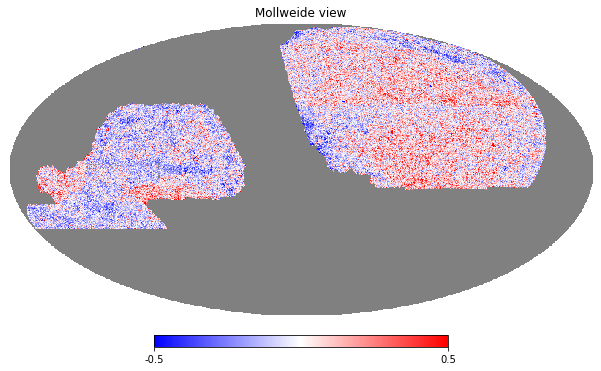

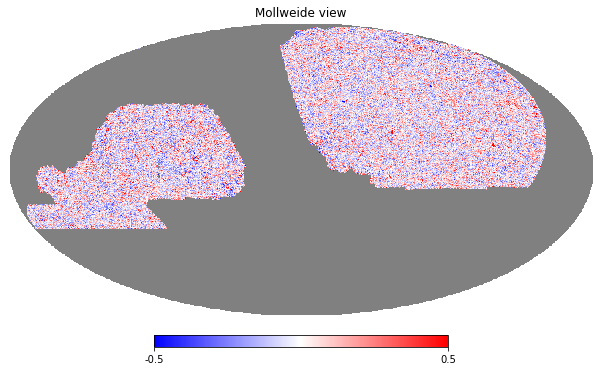

In [13]:
hp.mollview(delta_n, rot=-88, cmap=plt.cm.bwr, min=-0.5, max=0.5)
hp.mollview(delta_nw, rot=-88, cmap=plt.cm.bwr, min=-0.5, max=0.5)

In [11]:
from lssutils.lab import MeanDensity

nbars = {}
nbar = MeanDensity(ngal, frac, mask, syst)
nbar.run()
nbars['null'] = nbar.output

In [12]:
nbars_ = []

for i in range(20):
    
    wnn = makehp(wnn_['hpix'], wnn_['weight'][:, i], nside)
    wnn = wnn / wnn[mask].mean()
    wnn = wnn.clip(0.5, 2.0)

    nbar_ = MeanDensity(ngal, frac, mask, syst, selection=wnn)
    nbar_.run()
    nbars_.append(nbar_.output)
    print('.', end='')

....................

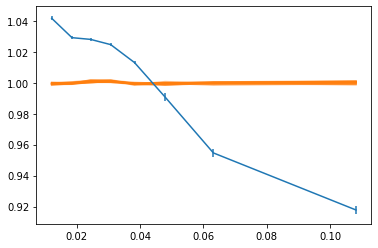

In [14]:
for name, nbar_i in nbars.items():
    plt.errorbar(nbar_i['bin_avg'], nbar_i['nnbar'], yerr=nbar_i['nnbar_err'], label=name)
    
for nbar_i in nbars_:
    plt.plot(nbar_i['bin_avg'], nbar_i['nnbar'], color='C1', alpha=0.5)

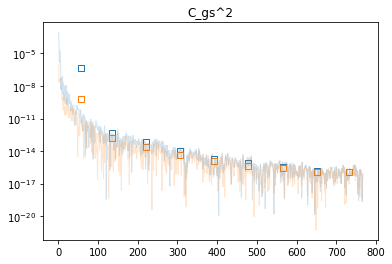

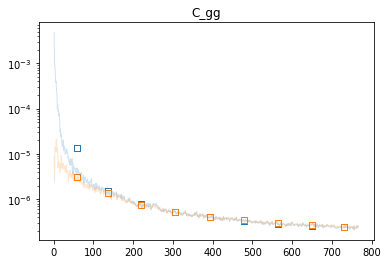

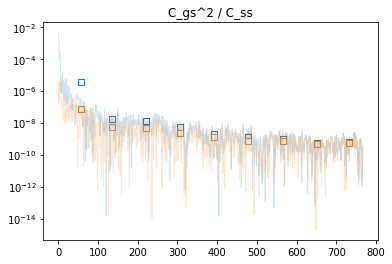

(-0.2, 0.2)

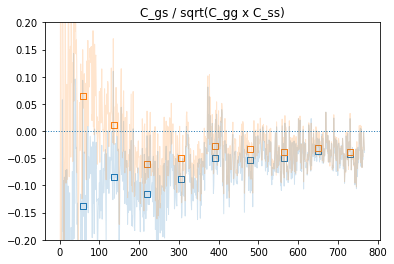

In [25]:
plt.title('C_gs^2')
plot_bin(cl_gs['null']['cl']**2)
for cl_gs_i in cl_gs_[:1]:
    plot_bin(cl_gs_i['cl']**2, color='C1')    
# plt.xscale('log')
plt.yscale('log')
plt.show()

plt.title('C_gg')
plot_bin(cl_gg['null']['cl'])
for cl_gg_i in cl_gg_[:1]:
    plot_bin(cl_gg_i['cl'], color='C1')
# plt.xscale('log')
plt.yscale('log')
plt.show()

plt.title('C_gs^2 / C_ss')
plot_bin(cl_gs['null']['cl']**2/cl_ss['cl'])

for cl_gs_i in cl_gs_[:1]:
    plot_bin(cl_gs_i['cl']**2/cl_ss['cl'], color='C1')
# plt.xscale('log')
plt.yscale('log')
plt.show()

plt.title('C_gs / sqrt(C_gg x C_ss)')
plot_bin(cl_gs['null']['cl']/np.sqrt(cl_gg['null']['cl']*cl_ss['cl']))
i = 0
for cl_gs_i in cl_gs_[:1]:
    plot_bin(cl_gs_i['cl']/np.sqrt(cl_gg_[i]['cl']*cl_ss['cl']), color='C1')
    i +=  1
    
# plot_bin(cl_gs['mitig']['cl']/np.sqrt(cl_gg['mitig']['cl']*cl_ss['cl']))
plt.axhline(0.0, ls=':', lw=1)
# plt.xscale('log')
# plt.yscale('log')
plt.ylim(-0.2, .2)

In [ ]:
# look at the C_gg ratio before to that of after for ell > 100
# plot ell^p*C_gs with Gaussian error-bars p = 1 or 2

(-1.0, 1.0)

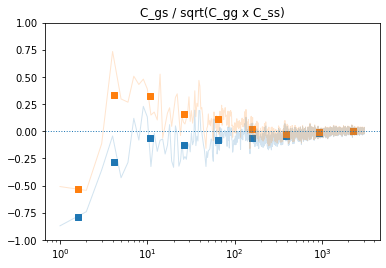

In [15]:
plt.title('C_gs / sqrt(C_gg x C_ss)')
plot_bin(cl_gs['null']/np.sqrt(cl_gg['null']*cl_ss))
plot_bin(cl_gs['mitig']/np.sqrt(cl_gg['mitig']*cl_ss))
plt.axhline(0.0, ls=':', lw=1)
plt.xscale('log')
# plt.yscale('log')
plt.ylim(-1.0, 1.)